In [58]:
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator
import sqlite3
import csv
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit import DataStructs
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results

In [107]:
conn = sqlite3.connect('database.db')
# Create a cursor object
cursor = conn.cursor()

# SQL query to select data
query = "SELECT * FROM assays INNER JOIN compounds ON assays.cid = compounds.cid;"  # Replace with your query
cursor.execute(query)
data = cursor.fetchall()
cid = [x[0] for x in data]
f_avg_IC50 = [x[1] for x in data]
r_avg_IC50 = [x[2] for x in data]
smiles = [x[4] for x in data]
hbd = [x[5] for x in data]
hba = [x[6] for x in data]
c_logp = [x[7] for x in data]
mw = [x[8] for x in data]
all_satisfied = [x[9] for x in data]

df = pd.DataFrame({
    'cid': cid,
    'f_avg_IC50': f_avg_IC50,
    'r_avg_IC50': r_avg_IC50,
    'smiles': smiles,
    'hbd': hbd,
    'hba': hba,
    'c_logp': c_logp,
    'mw': mw,
    'all_satisfied': all_satisfied
})

conn.close()

df.head()

,cid,f_avg_IC50,r_avg_IC50,smiles,hbd,hba,c_logp,mw,all_satisfied
0,DAR-DIA-23aa0b97-19,26.719515,14.641091,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,1,4,3.28768,287.322,1
1,DAR-DIA-23aa0b97-20,57.590417,45.077469,O=C(Cc1cncc2ccccc12)Nc1ccccc1,1,3,3.41600,262.312,1
2,TRY-UNI-714a760b-3,4.222340,8.201698,Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1,3,4,2.80682,275.739,1
3,TRY-UNI-714a760b-6,24.581194,13.895165,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,1,3,3.22462,260.724,1
4,TRY-UNI-714a760b-12,64.508813,45.689263,Cc1ccncc1NC(=O)Nc1cccc(Cl)c1,2,4,3.68742,261.712,1


In [60]:
print("Shape of dataframe : ", df.shape)
df.head()

Shape of dataframe :  (633, 9)


,cid,f_avg_IC50,r_avg_IC50,smiles,hbd,hba,c_logp,mw,all_satisfied
0,DAR-DIA-23aa0b97-19,26.719515,14.641091,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,1,4,3.28768,287.322,1
1,DAR-DIA-23aa0b97-20,57.590417,45.077469,O=C(Cc1cncc2ccccc12)Nc1ccccc1,1,3,3.41600,262.312,1
2,TRY-UNI-714a760b-3,4.222340,8.201698,Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1,3,4,2.80682,275.739,1
3,TRY-UNI-714a760b-6,24.581194,13.895165,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,1,3,3.22462,260.724,1
4,TRY-UNI-714a760b-12,64.508813,45.689263,Cc1ccncc1NC(=O)Nc1cccc(Cl)c1,2,4,3.68742,261.712,1


In [61]:
# Keep only the columns we want
df = df[["cid", "smiles", "f_avg_IC50", "r_avg_IC50"]]
df.head()
# NBVAL_CHECK_OUTPUT



,cid,smiles,f_avg_IC50,r_avg_IC50
0,DAR-DIA-23aa0b97-19,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,26.719515,14.641091
1,DAR-DIA-23aa0b97-20,O=C(Cc1cncc2ccccc12)Nc1ccccc1,57.590417,45.077469
2,TRY-UNI-714a760b-3,Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1,4.222340,8.201698
3,TRY-UNI-714a760b-6,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,24.581194,13.895165
4,TRY-UNI-714a760b-12,Cc1ccncc1NC(=O)Nc1cccc(Cl)c1,64.508813,45.689263


In [62]:
# Add column for activity
df["active"] = np.zeros(len(df))

# Mark every molecule as active with an pIC50 of >= 6.3, 0 otherwise
df.loc[df[df.f_avg_IC50 <= 100].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(df.active.sum()))
print("Number of inactive compounds:", len(df) - int(df.active.sum()))

Number of active compounds: 632
Number of inactive compounds: 1


In [63]:
def smiles_to_fp(smiles, method="morgan2", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [64]:
compound_df = df.copy()


In [65]:
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp)
compound_df.head(3)



,cid,smiles,f_avg_IC50,r_avg_IC50,active,fp
0,DAR-DIA-23aa0b97-19,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,26.719515,14.641091,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,DAR-DIA-23aa0b97-20,O=C(Cc1cncc2ccccc12)Nc1ccccc1,57.590417,45.077469,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,TRY-UNI-714a760b-3,Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1,4.222340,8.201698,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [101]:
from sklearn.metrics import mean_squared_error

def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    y_pred = ml_model.predict(test_x)
    rmse = mean_squared_error(test_y, y_pred, squared = False)

    print(rmse)
    return y_pred

In [78]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.f_avg_IC50.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 506
Test data size: 127


In [93]:
# Set model parameter for random forest
param = {
    "n_estimators": 10,  # number of trees to grows
    "criterion": "squared_error",  # cost function to be optimized for a split
}
model_RF = RandomForestRegressor(**param)

In [103]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

25.945343629388756


506


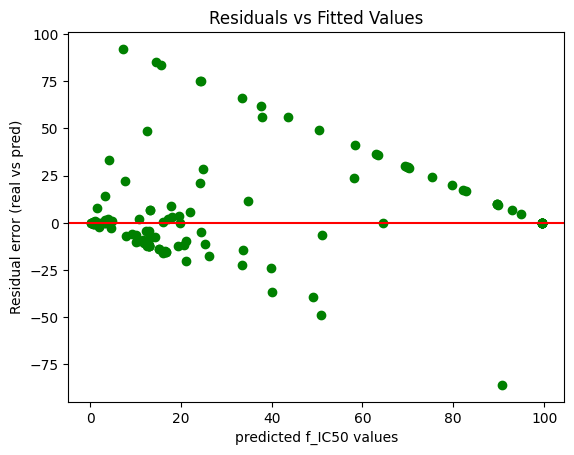

In [106]:
import matplotlib.pyplot as plt
print(len(static_train_y))

residual = static_test_y - performance_measures
plt.scatter(performance_measures, residual, c="green")
plt.xlabel('predicted f_IC50 values')
plt.ylabel('Residual error (real vs pred)')
plt.title('Residuals vs Fitted Values')
plt.axhline(y=0, color='red', linestyle='-')
plt.show()
